# Зображення як багтовимірні масиви та підготовка зображеннь до подальшого аналіщу.

In [8]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import skimage  # scikit-image

Корекція фонової інтенсивності

Оформлення всіх кроків корекції фонової інтенсивності у функцію

In [1]:
def background_correction(input_img:np.ndarray, background_percentile:float=1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

NameError: name 'np' is not defined

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def select_region(input_img:np.ndarray,y1,y2,x1,x2):
    crop_image = input_img[y1:y2,x1:x2]
    plt.figure(figsize=(5,5))
    plt.imshow(crop_image, cmap='Greys_r')
    return crop_image.astype(input_img.dtype)

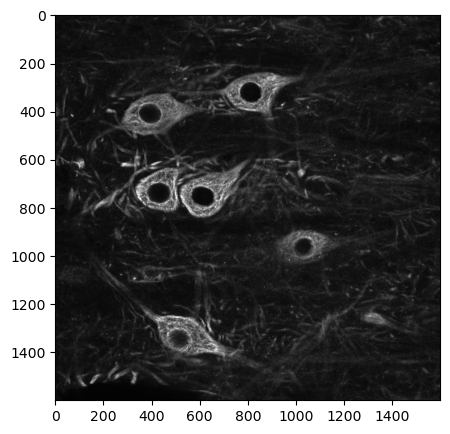

In [5]:
import tifffile as tiff
image = tiff.imread('../demo_data/2D_grey_matter_neurofilaments.tif')
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys_r')

In [ ]:
def background_correction(input_img:np.ndarray, background_percentile:float =1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

Acridine Orange images were acquired using a 20× objective on the Cytation 5 imaging system. Image acquisition utilized the following LED cube channels:
1. GFP channel (excitation/emission = 469/525 nm) for the visualization of nuclei, nucleoli, and cytoplasm;
2. PI channel (excitation/emission = 531/647 nm) for the detection of acidic vesicles.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def crop_function(input_img: np.ndarray, x1, x2, y1, y2):
    
    crop_image = input_img[y1:y2, x1:x2]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img)
    
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, 
        linewidth=2, edgecolor='red', facecolor='none'
    )
    
    ax[0].add_patch(rect)
    ax[0].set_title("Original Image (ROI highlighted)")
    
    ax[1].imshow(crop_image)
    ax[1].set_title("Cropped ROI")
    
    plt.tight_layout()
    plt.show()
    
    return crop_image.astype(input_img.dtype)

In [10]:
import tifffile as tiff 
GFP =  tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_1_9_GFP_001.tif")
PI =  tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_2_9_Propidium Iodide_001.tif")

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def background_correction(input_img: np.ndarray, background_percentile: float = 1):
  

    back_int = np.percentile(input_img, background_percentile)

    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img, cmap='Greys_r')
    ax[0].set_title("Original Image")

    ax[1].imshow(corr_img, cmap='Greys_r')
    ax[1].set_title(f"Background-corrected (−{background_percentile}th percentile)")


    plt.tight_layout()
    plt.show()

    return corr_img.astype(input_img.dtype)


2. Shadding correction

In [32]:
import numpy as np
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter

def estimate_flatfield(image_paths, sigma_px=60):
    """
    image_paths: list of TIFF paths from the SAME channel (10–20+ fields).
    sigma_px: Gaussian blur in pixels (50–100 typical for HCS fields).
    returns: float32 flat-field with median ~ 1.0
    """
    stack = [imread(p).astype(np.float32) for p in image_paths]
    med = np.median(np.stack(stack, axis=0), axis=0)       # multiplicative pattern
    ff  = gaussian_filter(med, sigma=sigma_px)             # smooth to illumination field
    # guard against zeros and normalize
    ff[ff <= 1e-6] = np.median(ff[ff > 0])
    ff /= np.median(ff)
    return ff.astype(np.float32)

In [43]:
from pathlib import Path

# 1. Get ~10–20 representative fields from one channel (e.g., GFP)
data_dir = Path("/Users/romankoval/data/GFP_train/")
image_paths = sorted(data_dir.glob("*.tif"))[:20]  # adjust number and extension

# 2. Estimate flat-field
ff = estimate_flatfield(image_paths, sigma_px=60)




In [44]:
def apply_flatfield(img, ff):
    """
    Divide by flat-field and rescale back to original dtype range (16-bit safe).
    """
    out = img.astype(np.float32) / ff
    if np.issubdtype(img.dtype, np.integer):
        info = np.iinfo(img.dtype)
        out = np.clip(out, 0, info.max).astype(img.dtype)
    else:
        out = out.astype(img.dtype)
    return out

In [48]:
img_corr = GFP.astype(np.float32) / ff
img_corr = np.clip(img_corr, 0, np.iinfo(np.uint16).max).astype(np.uint16)

In [47]:
apply_flatfield(GFP, ff)


array([[ 6863,  6746,  6712, ...,  5014,  4554,  4586],
       [ 6712,  6746,  6561, ...,  4649,  5062,  4602],
       [ 6611,  6443,  6863, ...,  4887,  4983,  5014],
       ...,
       [ 9934, 10611, 10763, ...,  6024,  5788,  5838],
       [10188,  9951, 10865, ...,  5636,  5855,  5551],
       [ 9934, 10357, 10780, ...,  5788,  6108,  5889]],
      shape=(904, 1224), dtype=uint16)

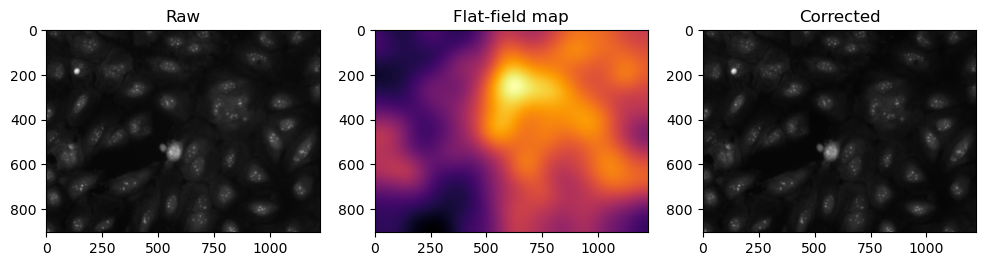

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(GFP, cmap='gray'); plt.title("Raw")

plt.subplot(1,3,2)
plt.imshow(ff, cmap='inferno'); plt.title("Flat-field map")

plt.subplot(1,3,3)
plt.imshow(img_corr, cmap='gray'); plt.title("Corrected")
plt.show()


3. Background correction

In [23]:
import numpy as np
import tifffile as tiff
import skimage
import matplotlib.pyplot as plt

def background_correction(input_img: np.ndarray, radius: int = 50):
    """
    Performs background correction using rolling-ball algorithm from scikit-image.
    Visualizes raw, background, and corrected images side-by-side.
    """
    # Compute background
    background_img = skimage.restoration.rolling_ball(input_img, radius=radius)
    corr_img = input_img - background_img
    corr_img = corr_img.clip(min=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(input_img, cmap='gray')
    axes[0].set_title('Raw image')

    axes[1].imshow(background_img, cmap='gray')
    axes[1].set_title('Background')

    axes[2].imshow(corr_img, cmap='gray')
    axes[2].set_title('Corrected')

    plt.tight_layout()
    plt.show()
    
    return corr_img.astype(input_img.dtype)


?Чому при збільшенні радіусу подовжується час виконання команди, для 300 = майже 8 хв?

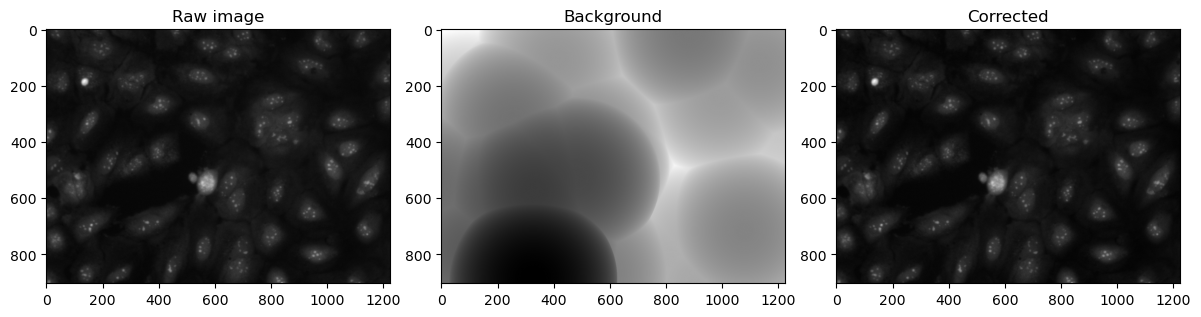

In [31]:
GFP_cor = background_correction(GFP, 300)

array([[6160, 6000, 6880, ..., 7520, 6960, 7424],
       [5968, 6064, 6032, ..., 7952, 7280, 7568],
       [5952, 6000, 5872, ..., 7360, 7008, 7072],
       ...,
       [5136, 5600, 5168, ..., 4976, 4688, 5152],
       [5568, 4896, 5456, ..., 4640, 4816, 4736],
       [5312, 5344, 5216, ..., 4400, 4704, 4976]],
      shape=(200, 200), dtype=uint16)

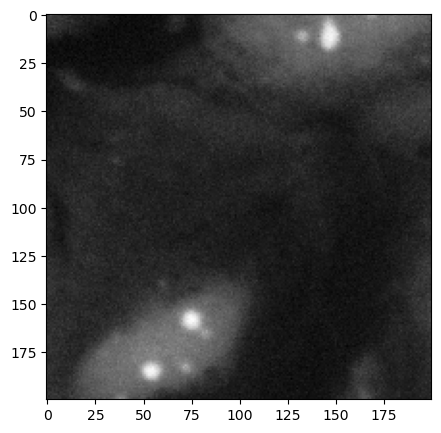

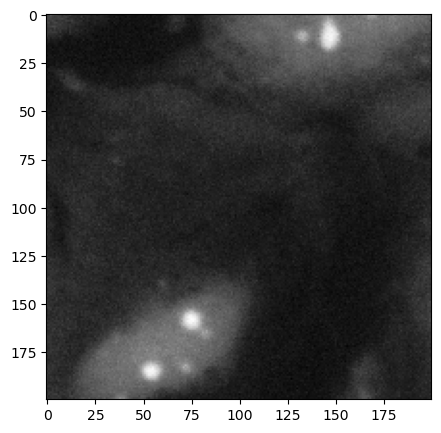

In [30]:
select_region(GFP_cor, 700,900, 200,400)
select_region(GFP, 700,900, 200,400)

In [2]:
import numpy as np
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter
from glob import glob
from pathlib import Path

def estimate_flat_dark(image_paths, sigma_px=60):
    """Estimate flat-field (multiplicative) and dark (additive) from many frames."""
    stack = [imread(p).astype(np.float32) for p in image_paths]
    med  = np.median(np.stack(stack, axis=0), axis=0)   # robust to cells moving
    dark = np.percentile(np.stack(stack, axis=0), 1, axis=0)  # near-min as additive
    flat = gaussian_filter(med, sigma=sigma_px)         # smooth illumination field
    flat = np.clip(flat, np.median(flat[flat>0])*0.1, None)   # guard against zeros
    # normalize flat so its median is 1
    flat /= np.median(flat)
    return flat.astype(np.float32), dark.astype(np.float32)

def apply_correction(img, flat, dark):
    corr = (img.astype(np.float32) - dark) / flat
    # rescale back to original dtype range
    corr -= corr.min()
    corr *= (np.iinfo(img.dtype).max / max(1e-6, corr.max()))

    return corr.astype(np.uint16)

In [2]:
paths = sorted(glob("/Users/romankoval/data/GFP_train/*.tif"))
flat, dark = estimate_flat_dark(paths, sigma_px=60)

In [62]:
img = tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_1_9_GFP_001.tif")
corr_image = apply_correction(img, flat, dark)


Text(0.5, 1.0, 'Corrected Image')

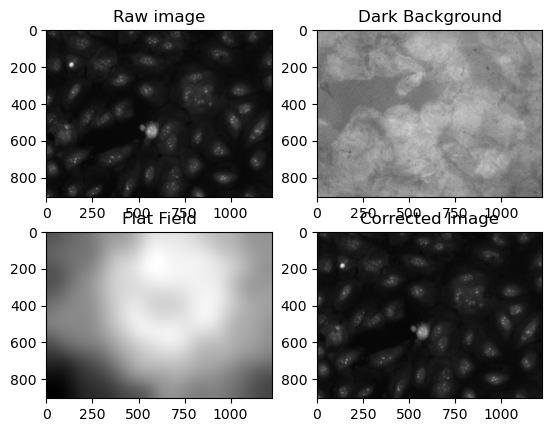

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Raw image')

axes[0, 1].imshow(dark, cmap='gray')
axes[0, 1].set_title('Dark Background')

axes[1, 0].imshow(flat, cmap='gray')
axes[1, 0].set_title('Flat Field')

axes[1, 1].imshow(corr_image, cmap='gray')
axes[1, 1].set_title('Corrected Image')

How change different env more or less automatically?

In [1]:
!pip install cellpose

  Using cached cellpose-4.0.7-py3-none-any.whl.metadata (22 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached roifile-2025.5.10-py3-none-any.whl.metadata (5.9 kB)
  Using cached segment_anything-1.0-py3-none-any.whl.metadata (487 bytes)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached cellpose-4.0.7-py3-none-any.whl (212 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 3.4 MB/s  0:00:21m0:00:0100:01m
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.5/658.5 kB 6.9 MB/s  0:00:00
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 3.0 MB/s

In [14]:
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, io, plot
from cellpose.models import CellposeModel


# -------- settings --------
img_dir   = Path("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/")
exts      = {".tif", ".tiff"}
channels  = (0, 0)        # 2D grayscale: cytoplasm=0, nucleus=0
diameter  = None          # let Cellpose estimate; set e.g. 12–18 if you know nuclei size
gpu       = True          # set False if no GPU
normalize = True          # normalize each image to [0,1] before inference

# -------- collect files --------
files = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in exts])
if not files:
    raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")

# -------- helper: read & sanity-check 2D --------
def read_2d(fp: Path, normalize01=True):
    img = tiff.imread(str(fp))
    if img.ndim != 2:
        raise ValueError(f"{fp.name} is not 2D; got shape {img.shape}")
    if normalize01:
        img = img.astype(np.float32, copy=False)
        mx, mn = float(img.max()), float(img.min())
        if mx > mn:
            img = (img - mn) / (mx - mn)
        else:
            img[:] = 0.0
    return img

# -------- load all 2D images --------
imgs = [read_2d(f, normalize01=normalize) for f in files]

# -------- cellpose model --------
io.logger_setup()
# Load the pre-trained cytoplasm model
model_cyto = CellposeModel(gpu = True, model_type='cyto')

# Load the pre-trained nuclei model
model_nuclei = CellposeModel(gpu = True, model_type='nuclei')



2025-10-13 10:45:46,744 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-13 10:45:46,744 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
2025-10-13 10:45:46,745 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 10:45:46,749 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 10:45:46,749 [INFO] >>>> using GPU (MPS)
2025-10-13 10:45:48,183 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 10:45:48,868 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 10:45:48,882 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 10:45:48,883 [INFO] >>>> using GPU (MPS)
2025-10-13 10:45:49,901 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam


2025-10-13 10:31:01,912 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 10:31:37,544 [INFO] 100%|##########| 2/2 [00:35<00:00, 17.81s/it]


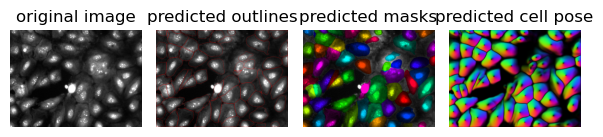

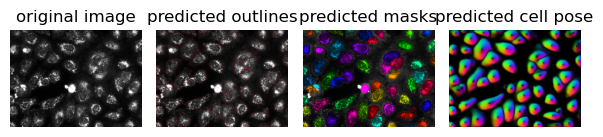

In [11]:


# batch eval: pass the whole list
masks_list, flows_list, styles = model.eval(
    imgs,
    diameter=diameter,
    flow_threshold=None,
    channels=channels
)

# -------- save & preview --------
out_dir = img_dir / "_cellpose_out"
out_dir.mkdir(exist_ok=True, parents=True)

for fp, img, masks, flows in zip(files, imgs, masks_list, flows_list):
    # save masks as uint16 label image
    tiff.imwrite(str(out_dir / f"{fp.stem}_cp_masks.tif"),
                 masks.astype(np.uint16), photometric="minisblack")

    # quick overlay
    fig = plt.figure(figsize=(6,5))
    try:
        flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
        plot.show_segmentation(fig, img, masks, flow_show, channels=channels)
    except Exception:
        overlay = plot.mask_overlay(img, masks)
        plt.imshow(overlay)
        plt.title("Mask overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models, io, plot

# ==== Settings ====
img_dir   = Path("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data")
exts      = {".tif", ".tiff"}
channels  = (0, 0)        # single-channel grayscale
diameters = {"cyto": None, "nuclei": None}  # set numbers if you know sizes
gpu       = True
normalize = True
preview_n = 1             # set >0 to preview first N images per model

# ==== Collect files ====
files = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in exts])
if not files:
    raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")




In [ ]:
# ==== Helpers ====
def read_2d(fp: Path, norm01=True):
    img = tiff.imread(str(fp))
    if img.ndim != 2:
        raise ValueError(f"{fp.name} is not 2D; got {img.shape}")
    if norm01:
        img = img.astype(np.float32, copy=False)
        mn, mx = float(img.min()), float(img.max())
        img = (img - mn) / (mx - mn) if mx > mn else np.zeros_like(img, dtype=np.float32)
    return img

def unpack_eval(out, n_imgs):
    """Handle Cellpose versions returning 3 or 4 items (or just masks)."""
    if isinstance(out, tuple):
        if len(out) == 4:
            return out  # masks_list, flows_list, styles, diams
        if len(out) == 3:
            masks_list, flows_list, styles = out
            diams = [None] * len(masks_list)
            return masks_list, flows_list, styles, diams
    # very old: may return only masks
    masks_list = out
    flows_list = [None] * n_imgs
    styles = None
    diams = [None] * n_imgs
    return masks_list, flows_list, styles, diams

In [17]:
# ==== Load images ====
imgs = [read_2d(f, norm01=normalize) for f in files]

# ==== Run both models ====
io.logger_setup()
out_root = img_dir / "_cellpose_out"
out_root.mkdir(parents=True, exist_ok=True)

for model_type in ("cyto", "nuclei"):
    print(f"\n>>> Running Cellpose model: {model_type}")
    model = models.CellposeModel(gpu=gpu, model_type=model_type)

    out = model.eval(
        imgs,
        diameter=diameters.get(model_type),
        flow_threshold=None,
        channels=channels
    )
    masks_list, flows_list, styles, diams = unpack_eval(out, n_imgs=len(imgs))

    # per-model output dir
    out_dir = out_root / model_type
    out_dir.mkdir(exist_ok=True, parents=True)

    # save & (optional) preview
    for i, (fp, img, masks, flows) in enumerate(zip(files, imgs, masks_list, flows_list)):
        # save label masks
        tiff.imwrite(
            str(out_dir / f"{fp.stem}_cp_{model_type}_masks.tif"),
            masks.astype(np.uint16),
            photometric="minisblack"
        )

        # optional quick preview for first N images
        if i < preview_n:
            plt.figure(figsize=(6, 5))
            try:
                flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
                plot.show_segmentation(plt.gcf(), img, masks, flow_show, channels=channels)
            except Exception:
                overlay = plot.mask_overlay(img, masks)
                plt.imshow(overlay); plt.title(f"{fp.name} • {model_type}"); plt.axis("off")
            plt.tight_layout(); plt.show()

    print(f"Saved masks to: {out_dir}")

2025-10-13 10:54:53,149 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-13 10:54:53,149 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0

>>> Running Cellpose model: cyto
2025-10-13 10:54:53,150 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 10:54:53,155 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 10:54:53,155 [INFO] >>>> using GPU (MPS)
2025-10-13 10:54:54,583 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 10:54:55,308 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 10:56:05,057 [INFO] 100%|##########| 4/4 [01:09<00:00, 17.44s/it]
Saved masks to: /Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/_cellpose_out/cyto

>>> Running Cellpose model: nuclei
2025-10-13 10:56:05,077 [WARNING] model_type argument is not used 

In [18]:
from pathlib import Path
from typing import Iterable, Dict, Optional, Tuple, List
import numpy as np
import tifffile as tiff
from cellpose import models, io, plot

def cell_segment(
    img_dir: Path,
    out_root: Optional[Path] = None,
    model_types: Iterable[str] = ("nuclei",),         # ("cyto", "nuclei") to run both
    channels: Tuple[int, int] = (0, 0),               # 2D grayscale
    diameters: Optional[Dict[str, Optional[float]]] = None,  # e.g., {"nuclei": 14, "cyto": 30}
    normalize01: bool = True,                         # per-image min-max → [0,1]
    gpu: bool = True,
    preview_n: int = 0                                # show first N overlays per model
) -> Dict[str, List[Path]]:
    """
    Segment 2D TIF/TIFF images with Cellpose.

    Parameters
    ----------
    img_dir : Path
        Folder with input *.tif/*.tiff (searched recursively).
    out_root : Path | None
        Where to write outputs; default = img_dir/'_cellpose_out'.
    model_types : iterable of {'cyto','nuclei'}
        Which Cellpose models to run.
    channels : (int,int)
        Cellpose channel mapping; for single-channel grayscale keep (0,0).
    diameters : dict[str, float|None] | None
        Optional per-model diameter; None lets Cellpose estimate.
    normalize01 : bool
        If True, min-max scale each image to [0,1].
    gpu : bool
        Enable GPU if available.
    preview_n : int
        If >0, show quick overlays for first N images per model.

    Returns
    -------
    outputs : dict
        Map model_type -> list of paths to saved mask TIFFs.
    """
    io.logger_setup()

    img_dir = Path(img_dir).expanduser().resolve()
    if not img_dir.exists():
        raise FileNotFoundError(f"Input folder does not exist: {img_dir}")

    exts = {".tif", ".tiff"}
    files = sorted(p for p in img_dir.rglob("*") if p.is_file() and p.suffix.lower() in exts)
    if not files:
        raise FileNotFoundError(f"No images with {tuple(exts)} found in {img_dir}")

    if out_root is None:
        out_root = img_dir / "_cellpose_out"
    out_root.mkdir(parents=True, exist_ok=True)

    if diameters is None:
        diameters = {}
    model_types = tuple(model_types)

    def read_2d(fp: Path) -> np.ndarray:
        img = tiff.imread(str(fp))
        if img.ndim != 2:
            raise ValueError(f"{fp.name} is not 2D; got shape {img.shape}")
        if normalize01:
            img = img.astype(np.float32, copy=False)
            mn, mx = float(img.min()), float(img.max())
            if mx > mn:
                img = (img - mn) / (mx - mn)
            else:
                img = np.zeros_like(img, dtype=np.float32)
        return img

    def unpack_eval(out, n_imgs):
        # Handle different Cellpose versions (3 vs 4 return values vs just masks)
        if isinstance(out, tuple):
            if len(out) == 4:
                return out  # masks_list, flows_list, styles, diams
            if len(out) == 3:
                masks_list, flows_list, styles = out
                diams = [None] * len(masks_list)
                return masks_list, flows_list, styles, diams
        masks_list = out
        flows_list = [None] * n_imgs
        styles = None
        diams = [None] * n_imgs
        return masks_list, flows_list, styles, diams

    # Load all images (keeps code simple; for huge sets, stream per-image instead)
    imgs = [read_2d(f) for f in files]

    results: Dict[str, List[Path]] = {}

    for model_type in model_types:
        out_dir = out_root / model_type
        out_dir.mkdir(parents=True, exist_ok=True)

        model = models.CellposeModel(gpu=gpu, model_type=model_type)
        out = model.eval(
            imgs,
            diameter=diameters.get(model_type),
            flow_threshold=None,
            channels=channels
        )
        masks_list, flows_list, styles, diams = unpack_eval(out, n_imgs=len(imgs))

        saved_paths: List[Path] = []
        for i, (fp, img, masks, flows) in enumerate(zip(files, imgs, masks_list, flows_list)):
            save_path = out_dir / f"{fp.stem}_cp_{model_type}_masks.tif"
            tiff.imwrite(str(save_path), masks.astype(np.uint16), photometric="minisblack")
            saved_paths.append(save_path)

            if i < preview_n:
                import matplotlib.pyplot as plt
                try:
                    flow_show = flows[0] if isinstance(flows, (list, tuple)) else flows
                    plot.show_segmentation(plt.gcf(), img, masks, flow_show, channels=channels)
                except Exception:
                    overlay = plot.mask_overlay(img, masks)
                    plt.imshow(overlay); plt.title(f"{fp.name} • {model_type}"); plt.axis("off")
                plt.tight_layout(); plt.show()

        results[model_type] = saved_paths

    return results


2025-10-13 11:03:31,867 [INFO] WRITING LOG OUTPUT TO /Users/romankoval/.cellpose/run.log
2025-10-13 11:03:31,867 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.13.7 
torch version:  	2.8.0
2025-10-13 11:03:31,936 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 11:03:31,940 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 11:03:31,940 [INFO] >>>> using GPU (MPS)
2025-10-13 11:03:33,352 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 11:03:34,026 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 11:07:08,398 [INFO] 100%|##########| 12/12 [03:34<00:00, 17.86s/it]


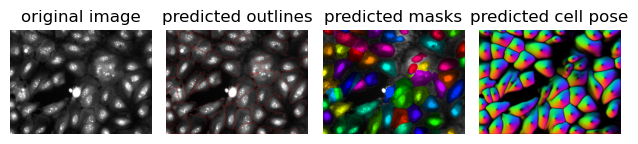

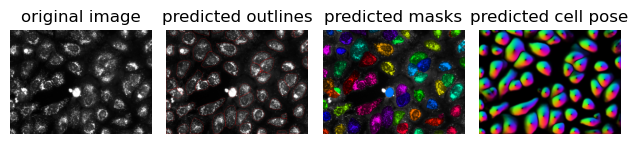

2025-10-13 11:07:09,790 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-10-13 11:07:09,799 [INFO] ** TORCH MPS version installed and working. **
2025-10-13 11:07:09,799 [INFO] >>>> using GPU (MPS)
2025-10-13 11:07:11,380 [INFO] >>>> loading model /Users/romankoval/.cellpose/models/cpsam
2025-10-13 11:07:12,047 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-10-13 11:07:12,049 [INFO] 0%|          | 0/12 [00:00<?, ?it/s]
2025-10-13 11:08:33,515 [WARNING] Resizing is deprecated in v4.0.1+
2025-10-13 11:08:33,571 [INFO] 8%|8         | 1/12 [01:21<14:56, 81.52s/it]
2025-10-13 11:10:02,986 [WARNING] Resizing is deprecated in v4.0.1+
2025-10-13 11:10:03,035 [INFO] 17%|#6        | 2/12 [02:50<14:21, 86.19s/it]
2025-10-13 11:11:30,945 [WARNING] Resizing is deprecated in v4.0.1+
2025-10-13 11:11:30,994 [INFO] 25%|##5       | 3/12 [04:18<13:02, 87.00s/it]
2025-10-13 11:12:59,901 [WARNI

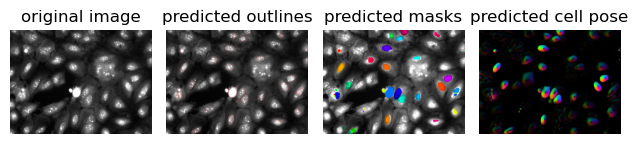

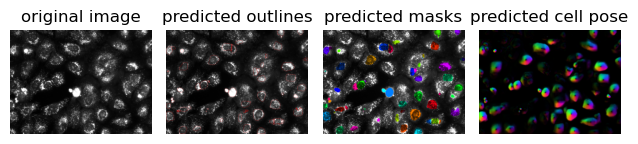

{'cyto': 12, 'nuclei': 12}


In [22]:
from pathlib import Path

outputs = cell_segment(
    img_dir=Path("./my_data"),
    model_types=("cyto","nuclei"),
    diameters={"nuclei": 14, "cyto": 30},  # or leave None to auto
    channels=(0,0),
    gpu=True,
    preview_n=2
)
print({k: len(v) for k,v in outputs.items()})


Pixel binning

Compared 1×1 (full resolution) vs 2×2 binning (pixel averaging).

Result: No detectable loss of morphological profile quality with 2×2 binning (Figure 5C).

Benefit:

4× reduction in image file size,

Significant reduction in data storage and compute time.

Recommendation: Use 2×2 binning whenever possible.

In [24]:
import my_def

In [27]:
help(cell_segment)

Help on function cell_segment in module __main__:

cell_segment(
    img_dir: pathlib._local.Path,
    out_root: Optional[pathlib._local.Path] = None,
    model_types: Iterable[str] = ('nuclei',),
    channels: Tuple[int, int] = (0, 0),
    diameters: Optional[Dict[str, Optional[float]]] = None,
    normalize01: bool = True,
    gpu: bool = True,
    preview_n: int = 0
) -> Dict[str, List[pathlib._local.Path]]
    Segment 2D TIF/TIFF images with Cellpose.

    Parameters
    ----------
    img_dir : Path
        Folder with input *.tif/*.tiff (searched recursively).
    out_root : Path | None
        Where to write outputs; default = img_dir/'_cellpose_out'.
    model_types : iterable of {'cyto','nuclei'}
        Which Cellpose models to run.
    channels : (int,int)
        Cellpose channel mapping; for single-channel grayscale keep (0,0).
    diameters : dict[str, float|None] | None
        Optional per-model diameter; None lets Cellpose estimate.
    normalize01 : bool
        If Tr